# Geoscripting Exercise 12 GISRSArtists
## 22 January 2019

Imports

In [1]:
import rasterio
import rasterstats as rs
import matplotlib.pyplot as plt
import geopandas as gpd
from owslib.wcs import WebCoverageService
from owslib.wfs import WebFeatureService
from python.createBoundingBox import createBoundingBox
from python.writeGeotiffToFile import writeGeotiffToFile
from python.getGeotiffFromWebCoverageService import getGeotiffFromWebCoverageService
from python.getDataFromWebFeatureService import getDataFromWebFeatureService
from python.calculateBuildingVolume import calculateBuildingVolume
from python.visualizeBuildingVolume import visualizeBuildingVolume

In [2]:
# specify coordinates (Wageningen University)
x, y = 174100, 444100

# create bounding box around coordinates
bbox = createBoundingBox(x, y, 1000, 1000)
print("bbox: " + str(bbox))

# get wcs of Wageningen
url = 'http://geodata.nationaalgeoregister.nl/ahn2/wcs?service=WCS'
version = '1.0.0'
direc = 'data'
frmt = 'GEOTIFF_FLOAT32'
getGeotiffFromWebCoverageService(url, version, bbox, 
                                 'ahn2_05m_ruw', frmt, direc, 'AHN2_05m_DSM')
getGeotiffFromWebCoverageService(url, version, bbox, 
                                 'ahn2_05m_int', frmt, direc, 'AHN2_05m_DTM')


bbox: (173600.0, 443600.0, 174600.0, 444600.0)


/home/WUR/leens006/miniconda3/envs/rasterpython/lib/python3.7/site-packages/owslib/feature/wfs200.py:120: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if serviceproviderelem:


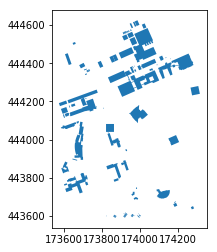

In [3]:
# get wfs of Wageningen
bgtURL = 'https://geodata.nationaalgeoregister.nl/beta/bgt/wfs'
bgtversion = '2.0.0'
typename = 'bgt:pand'
buildingsGDF = getDataFromWebFeatureService(bgtURL, bgtversion, bbox, typename)

%matplotlib inline 
buildingsGDF.plot() # plot to check if download succeeded

In [4]:
# create heightmodel from difference DSM and DTM
DSM = rasterio.open("./data/AHN2_05m_DSM.tif", driver="GTiff")
DTM = rasterio.open("./data/AHN2_05m_DTM.tif", driver="GTiff")
buildingsHeight = DSM.read() - DTM.read()

# save to geotif
kwargs = DSM.meta # Copy metadata of rasterio.io.DatasetReader
writeGeotiffToFile(buildingsHeight, 'output', 'buildingsHeight', kwargs)

In [5]:
# calculate volume of buildings
volume = calculateBuildingVolume(buildingsGDF, "buildingsHeight.tif", "output")
buildingsGDF.loc[:,'volume'] = volume

# sum of all buildings' volumes 
totalVolume = sum(buildingsGDF.loc[:,'volume']) 
print("total volume: " + str(totalVolume))


/home/WUR/leens006/miniconda3/envs/rasterpython/lib/python3.7/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


total volume: 1389262.0063020994


/home/WUR/leens006/miniconda3/envs/rasterpython/lib/python3.7/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


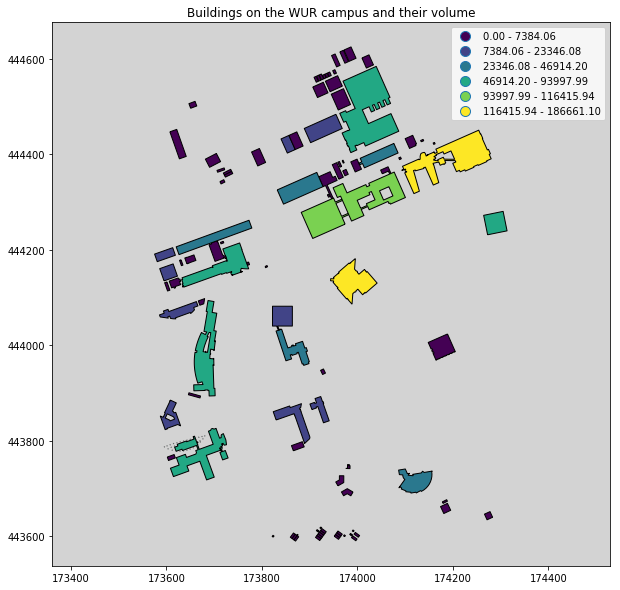

In [6]:
# plot buildingsvolume
visualizeBuildingVolume(buildingsGDF)
    